In [1]:
## This Notebook contains class and quantile version of BD-LSTM model on the following datasets
    # 1. Sunspot
    # 2. Mackey-Glass
    # 3. Lorenz

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import torch                                             # PyTorch - machine learning framework
import torch.nn as nn                                    # neural network
import torch.optim as optim
import matplotlib.pyplot as plt   
from reservoirpy.datasets import mackey_glass 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 

In [3]:
# Define Classes
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class BDLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BDLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc = nn.Linear(hidden_sizes[-1] * 2, output_size)  # * 2 because of bidirectional

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc(out[:, -1, :])
        return out

class BDLSTM_Quantile(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_quantiles, num_steps_ahead):
        super(BDLSTM_Quantile, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_size[0], batch_first=True, bidirectional=True))
        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_size[i-1] * 2, hidden_size[i], batch_first=True, bidirectional=True))
        
        # Define separate linear layers for each quantile
        self.fc = nn.ModuleList([nn.Linear(hidden_size[-1] * 2, self.num_steps_ahead) for _ in range(num_quantiles)])

    def forward(self, x):
        for lstm in self.lstms:
            x, _ = lstm(x)
        
        lstm_out = x[:, -1, :]  # Use the output of the last time step
        
        # Compute the outputs for each quantile
        quantile_outputs = [fc(lstm_out) for fc in self.fc]
        
        # Stack the quantile outputs
        output = torch.stack(quantile_outputs, dim=2)
        return output

# Define Functions
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

# Quantile loss function
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

def evaluate_model(model, test_dataloader, quantiles):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)  # Adjust dimensions if necessary
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles))  # Reshape targets
            outputs = model(inputs)  # Forward pass
            all_preds.append(outputs)
            all_targets.append(targets)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return all_preds, all_targets

In [4]:
Sunspot = pd.read_csv('data/Sunspots.csv')
response = Sunspot['Monthly Mean Total Sunspot Number']
scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(response).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [5]:
## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [6]:
# Hyperparameters
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50    # Default: 50, change for less intentive computation
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.017368
Epoch [10/50], Loss: 0.004064
Epoch [20/50], Loss: 0.004013
Epoch [30/50], Loss: 0.003999
Epoch [40/50], Loss: 0.003977
Epoch [50/50], Loss: 0.003957


In [7]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

## Calculate RMSE here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.080475


In [8]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(y_pred[:, step], y_test[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0603
At time step 2, Avg RMSE: 0.0726
At time step 3, Avg RMSE: 0.0746
At time step 4, Avg RMSE: 0.0841
At time step 5, Avg RMSE: 0.0906
At time step 6, Avg RMSE: 0.0954


In [9]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[ 57.423946  57.29353   57.017853  57.35821   60.008064  58.54694 ]
 [114.12247  112.4266   113.04634  110.97659  113.77548  112.095345]
 [248.71132  241.96014  245.97919  241.13335  243.25432  229.46953 ]
 ...
 [ 70.390526  68.417725  70.15673   71.504364  70.5047    68.173386]
 [133.51823  131.29147  131.08978  127.522896 132.48236  131.14958 ]
 [ 20.39426   19.748133  20.962696  21.403605  22.753864  23.220228]]
True values: [[ 62.399998  60.5       37.2       13.2       27.5       59.299995]
 [ 57.3       90.1      135.09999  179.90001  108.8       83.1     ]
 [271.       283.5      285.1      256.9      215.6      265.7     ]
 ...
 [ 94.        63.5       49.8       60.699997  96.5      160.3     ]
 [112.5      112.5      102.9      100.2      106.9      130.      ]
 [ 20.4       32.399998  28.3       39.9       10.099999   4.3     ]]


In [10]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 22.6776, MAPE on test set: 114630811503820800.0000%


In [11]:
# Similar to Linear regression results, we can see that MAPE is not appropriate here

In [12]:
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

actual_values_steps = list(zip(*actual_values))
predicted_values_steps = list(zip(*predicted_values))

for step in range(output_size):
    mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
    mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))
    print(f"At time step {step + 1}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

At time step 1, Avg MAE: 17.69, Avg MAPE: 86604344668979200.000%
At time step 2, Avg MAE: 20.32, Avg MAPE: 77617937619353600.000%
At time step 3, Avg MAE: 21.26, Avg MAPE: 85438173806592000.000%
At time step 4, Avg MAE: 23.87, Avg MAPE: 117060716095078400.000%
At time step 5, Avg MAE: 25.93, Avg MAPE: 157247114471014400.000%
At time step 6, Avg MAE: 26.99, Avg MAPE: 163816535385702400.000%


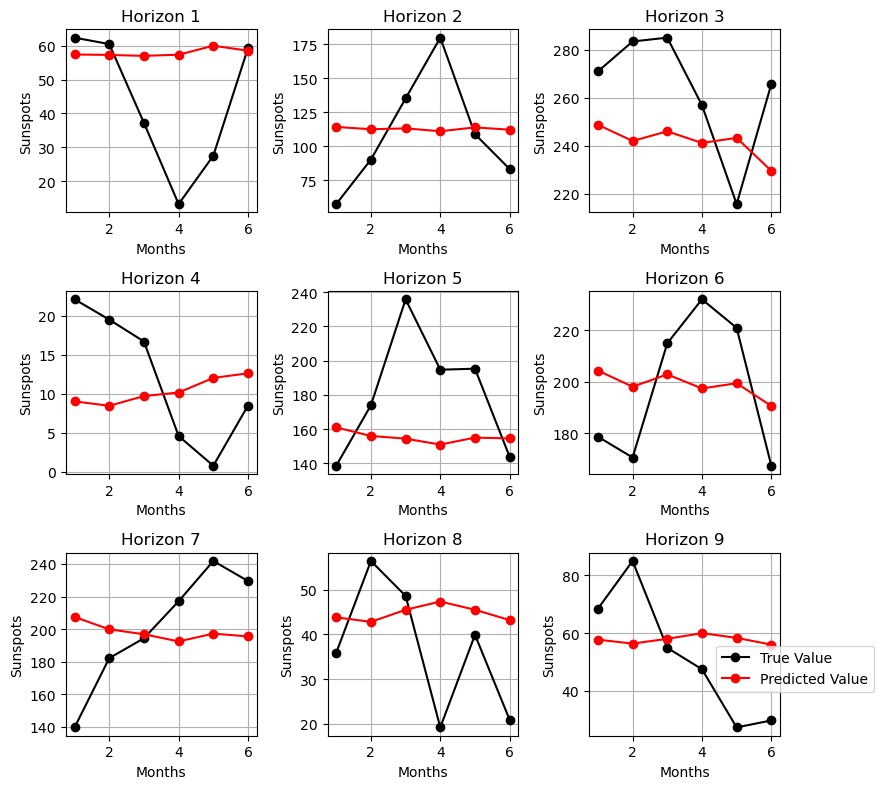

In [13]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspots')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [14]:
## BD-LSTM: Quantile Version

# Hyperparameters
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

In [15]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.081078
Epoch [10/50], Loss: 0.018536
Epoch [20/50], Loss: 0.017931
Epoch [30/50], Loss: 0.017786
Epoch [40/50], Loss: 0.017721
Epoch [50/50], Loss: 0.017664


In [16]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

In [17]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 6 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 6 time steps(RMSE):
Quantile 0.05: 0.136831
Quantile 0.25: 0.096731
Quantile 0.50: 0.080673
Quantile 0.75: 0.090744
Quantile 0.95: 0.158998


In [18]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(pred_050[: , step], actual_values[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0609
At time step 2, Avg RMSE: 0.0726
At time step 3, Avg RMSE: 0.0746
At time step 4, Avg RMSE: 0.0837
At time step 5, Avg RMSE: 0.0912
At time step 6, Avg RMSE: 0.0958


In [19]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [62.399998 60.5      37.2      13.2      27.5      59.299995]
At Quantile 0.05: [26.530582 22.546263 22.331896 19.059858 18.403868 14.856108]
At Quantile 0.25: [42.0638   39.582657 37.190613 38.27803  36.225037 33.077   ]
At Quantile 0.5: [53.40895  54.138317 53.522213 52.676533 53.197998 52.2581  ]
At Quantile 0.75: [67.42824  69.301735 72.380714 72.31612  73.6723   78.03548 ]
At Quantile 0.95: [ 94.66981  100.06472  105.49887  111.119644 116.43076  121.33013 ]
Actual Values: [ 57.3      90.1     135.09999 179.90001 108.8      83.1    ]
At Quantile 0.05: [70.54546  64.05711  58.14783  55.171066 53.846725 47.468548]
At Quantile 0.25: [94.650665 90.887764 87.478836 87.78844  82.61836  82.73133 ]
At Quantile 0.5: [112.5817  112.70243 112.2137  109.96517 110.97796 111.53555]
At Quantile 0.75: [133.53175 133.36247 138.28366 135.77353 138.40254 139.31871]
At Quantile 0.95: [172.24622 178.44339 179.86693 188.52895 191.32489 192.49226]
A

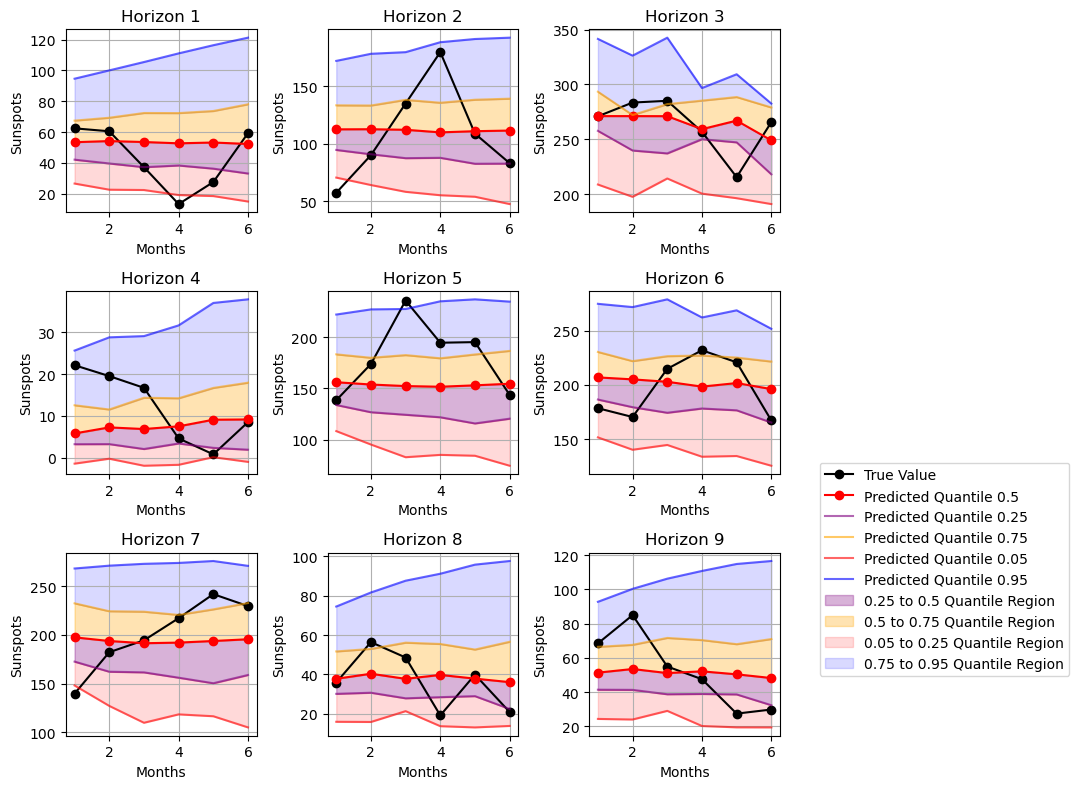

In [20]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], marker='o', linestyle='-', color='red', label='Predicted Quantile 0.5')
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspots')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [21]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Average Performance
MAE: 22.3662, MAPE: 84086816033996800.0000%


In [22]:
for step in range(output_size):
    mae_step = mean_absolute_error(predicted_050[: , step], actual_values[:, step])
    mape_step = mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step])
    print(f"At time step {step + 1}, predictions have MAE: {mae_step:.4f} and MAPE: {mape_step*100:.4f}%")

At time step 1, predictions have MAE: 17.6094 and MAPE: 40.5580%
At time step 2, predictions have MAE: 20.1815 and MAPE: 41.1652%
At time step 3, predictions have MAE: 20.8494 and MAPE: 41.5627%
At time step 4, predictions have MAE: 23.1732 and MAPE: 45.1512%
At time step 5, predictions have MAE: 25.5986 and MAPE: 47.2392%
At time step 6, predictions have MAE: 26.7851 and MAPE: 49.3452%


In [23]:
## 2. Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data)) 

scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [24]:
# Hyperparameters
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50    # Default: 50, change for less intentive computation
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.033438
Epoch [10/50], Loss: 0.008913
Epoch [20/50], Loss: 0.003510
Epoch [30/50], Loss: 0.002347
Epoch [40/50], Loss: 0.001469
Epoch [50/50], Loss: 0.000810


In [25]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

## Calculate RMSE here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.063216


In [26]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(y_pred[:, step], y_test[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0235
At time step 2, Avg RMSE: 0.0352
At time step 3, Avg RMSE: 0.0513
At time step 4, Avg RMSE: 0.0668
At time step 5, Avg RMSE: 0.0808
At time step 6, Avg RMSE: 0.0925


In [27]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[0.75010705 0.721416   0.6939068  0.67743355 0.66120845 0.64803094]
 [0.6373895  0.60552883 0.56059283 0.5394688  0.5275268  0.514015  ]
 [1.2502359  1.2404298  1.217432   1.1932586  1.1695759  1.1304225 ]
 ...
 [1.1273179  1.1349971  1.1335006  1.1379212  1.1304501  1.1289458 ]
 [1.1745166  1.1818362  1.1735699  1.1717553  1.160046   1.1511136 ]
 [0.7445676  0.7885651  0.8326165  0.8679612  0.9180834  0.9406486 ]]
True values: [[0.76436645 0.7505906  0.74230474 0.73766583 0.7347505  0.73197913]
 [0.6519387  0.61093843 0.57175744 0.5351325  0.50199467 0.4735659 ]
 [1.2665235  1.2604805  1.2386154  1.2023267  1.1553559  1.1022025 ]
 ...
 [1.0971459  1.0929141  1.0893244  1.089304   1.0955415  1.1097611 ]
 [1.141144   1.1264871  1.110162   1.0949793  1.0829287  1.0751301 ]
 [0.7430709  0.79422706 0.84594196 0.89670604 0.94570583 0.99227923]]


In [28]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 0.0436, MAPE on test set: 4.9827%


In [29]:
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

actual_values_steps = list(zip(*actual_values))
predicted_values_steps = list(zip(*predicted_values))

for step in range(output_size):
    mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
    mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))
    print(f"At time step {step + 1}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

At time step 1, Avg MAE: 0.02, Avg MAPE: 2.008%
At time step 2, Avg MAE: 0.03, Avg MAPE: 2.938%
At time step 3, Avg MAE: 0.04, Avg MAPE: 4.369%
At time step 4, Avg MAE: 0.05, Avg MAPE: 5.742%
At time step 5, Avg MAE: 0.06, Avg MAPE: 6.958%
At time step 6, Avg MAE: 0.07, Avg MAPE: 7.881%


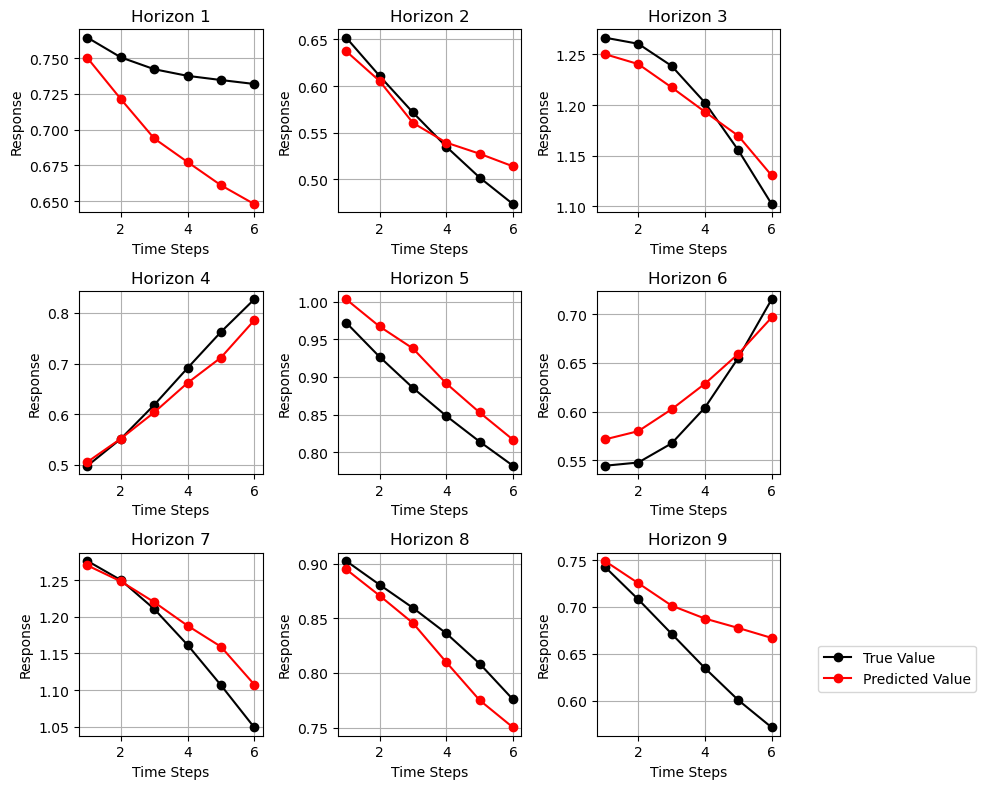

In [30]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [31]:
## Quantile Ver
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

In [32]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.222373
Epoch [10/50], Loss: 0.023671
Epoch [20/50], Loss: 0.018104
Epoch [30/50], Loss: 0.016477
Epoch [40/50], Loss: 0.015214
Epoch [50/50], Loss: 0.014283


In [33]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 6 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 6 time steps(RMSE):
Quantile 0.05: 0.119094
Quantile 0.25: 0.075749
Quantile 0.50: 0.062929
Quantile 0.75: 0.083540
Quantile 0.95: 0.127465


In [34]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(pred_050[: , step], actual_values[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0261
At time step 2, Avg RMSE: 0.0411
At time step 3, Avg RMSE: 0.0540
At time step 4, Avg RMSE: 0.0679
At time step 5, Avg RMSE: 0.0778
At time step 6, Avg RMSE: 0.0883


In [35]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [0.76436645 0.7505906  0.74230474 0.73766583 0.7347505  0.73197913]
At Quantile 0.05: [0.7297763 0.6698026 0.6288244 0.6008166 0.5566763 0.5338035]
At Quantile 0.25: [0.75076455 0.70800513 0.6726476  0.64404774 0.6150281  0.590668  ]
At Quantile 0.5: [0.763369   0.7321159  0.6996506  0.67530745 0.6573089  0.63448805]
At Quantile 0.75: [0.7768443  0.7505438  0.7298221  0.71229076 0.6878623  0.6671104 ]
At Quantile 0.95: [0.78926075 0.7669038  0.7752707  0.7742766  0.78134364 0.84092444]
Actual Values: [0.6519387  0.61093843 0.57175744 0.5351325  0.50199467 0.4735659 ]
At Quantile 0.05: [0.63226885 0.56659395 0.5184234  0.5093919  0.44081864 0.4358925 ]
At Quantile 0.25: [0.6592565  0.6066658  0.5713349  0.5374781  0.4968863  0.46575773]
At Quantile 0.5: [0.6689598  0.6269149  0.561004   0.5324891  0.5119162  0.47591558]
At Quantile 0.75: [0.6931185  0.6180462  0.5926453  0.5625742  0.5215413  0.50291055]
At Quantile 0.95: [0.675471

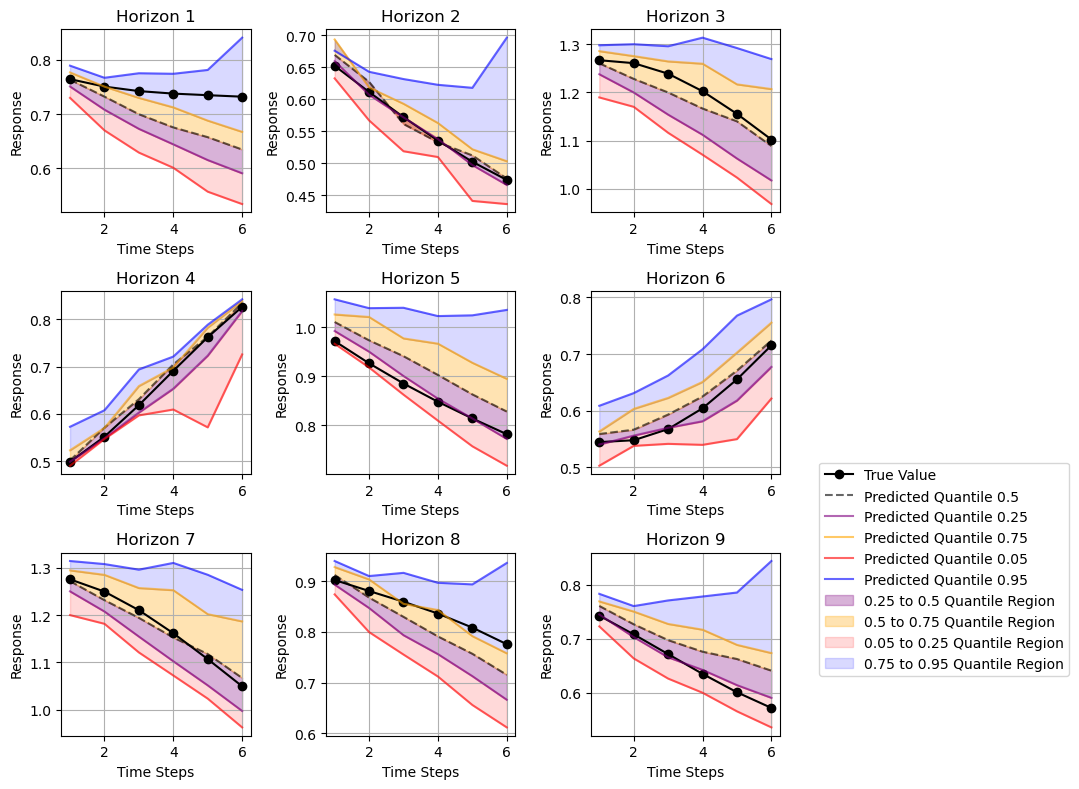

In [36]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [37]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Average Performance
MAE: 0.0420, MAPE: 4.6062%


In [38]:
for step in range(output_size):
    mae_step = mean_absolute_error(predicted_050[: , step], actual_values[:, step])
    mape_step = mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step])
    print(f"At time step {step + 1}, predictions have MAE: {mae_step:.4f} and MAPE: {mape_step*100:.4f}%")

At time step 1, predictions have MAE: 0.0186 and MAPE: 1.9844%
At time step 2, predictions have MAE: 0.0293 and MAPE: 3.0950%
At time step 3, predictions have MAE: 0.0384 and MAPE: 4.1059%
At time step 4, predictions have MAE: 0.0485 and MAPE: 5.1469%
At time step 5, predictions have MAE: 0.0550 and MAPE: 5.8460%
At time step 6, predictions have MAE: 0.0625 and MAPE: 6.6993%


In [39]:
## 3. Lorenz
def lorenz(xyz, *, s=10, r=28, b=2.667):
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# break it down to 3 univariate time series
x_dimension = xyzs[:, 0]
y_dimension = xyzs[:, 1]
z_dimension = xyzs[:, 2]

x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
y_dimension = y_dimension.flatten()
y_dimension = pd.Series(y_dimension, name='Value')
z_dimension = z_dimension.flatten()
z_dimension = pd.Series(z_dimension, name='Value')

x_dimension.index = range(len(x_dimension))
y_dimension.index = range(len(y_dimension))
z_dimension.index = range(len(z_dimension))
# print(x_dimension), print(y_dimension), print(z_dimension)

scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
y_reshaped = np.array(y_dimension).reshape(-1, 1)
z_reshaped = np.array(z_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()
y_scaled = scaler.fit_transform(y_reshaped).flatten()
z_scaled = scaler.fit_transform(z_reshaped).flatten()

In [40]:
# Fitting model on X Dimension

input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

In [41]:
# Hyperparameters
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50    # Default: 50, change for less intentive computation
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.019785
Epoch [10/50], Loss: 0.001617
Epoch [20/50], Loss: 0.000236
Epoch [30/50], Loss: 0.000110
Epoch [40/50], Loss: 0.000100
Epoch [50/50], Loss: 0.000095


In [42]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

## Calculate RMSE here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.008295


In [43]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(y_pred[:, step], y_test[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0027
At time step 2, Avg RMSE: 0.0045
At time step 3, Avg RMSE: 0.0059
At time step 4, Avg RMSE: 0.0083
At time step 5, Avg RMSE: 0.0106
At time step 6, Avg RMSE: 0.0130


In [44]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[36.426693  35.255844  34.072765  32.84993   31.675434  30.57264  ]
 [11.119804  10.734336  10.561148  10.168859  10.00783   10.0858   ]
 [ 4.255045   4.557353   5.4670277  6.4196997  7.6225815  9.005674 ]
 ...
 [23.251963  22.817049  22.555225  22.261045  21.99379   21.784586 ]
 [22.457212  22.30987   22.170902  22.055986  21.824635  21.521414 ]
 [31.351042  31.602179  32.083607  32.335384  32.688408  33.27734  ]]
True values: [[36.510597  35.390133  34.305557  33.2713    32.29794   31.392473 ]
 [11.1629    10.922095  10.7232    10.571853  10.473153  10.431415 ]
 [ 4.2965765  4.8387203  5.6347156  6.666791   7.9051147  9.31029  ]
 ...
 [23.240856  23.03548   22.835695  22.638214  22.440012  22.2383   ]
 [22.453465  22.35727   22.241537  22.106201  21.951002  21.775482 ]
 [31.457817  31.869795  32.316288  32.799362  33.321022  33.883118 ]]


In [45]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 0.2612, MAPE on test set: 1.5035%


In [46]:
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

actual_values_steps = list(zip(*actual_values))
predicted_values_steps = list(zip(*predicted_values))

for step in range(output_size):
    mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
    mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))
    print(f"At time step {step + 1}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

At time step 1, Avg MAE: 0.09, Avg MAPE: 0.529%
At time step 2, Avg MAE: 0.16, Avg MAPE: 1.001%
At time step 3, Avg MAE: 0.20, Avg MAPE: 1.186%
At time step 4, Avg MAE: 0.29, Avg MAPE: 1.635%
At time step 5, Avg MAE: 0.37, Avg MAPE: 2.055%
At time step 6, Avg MAE: 0.46, Avg MAPE: 2.614%


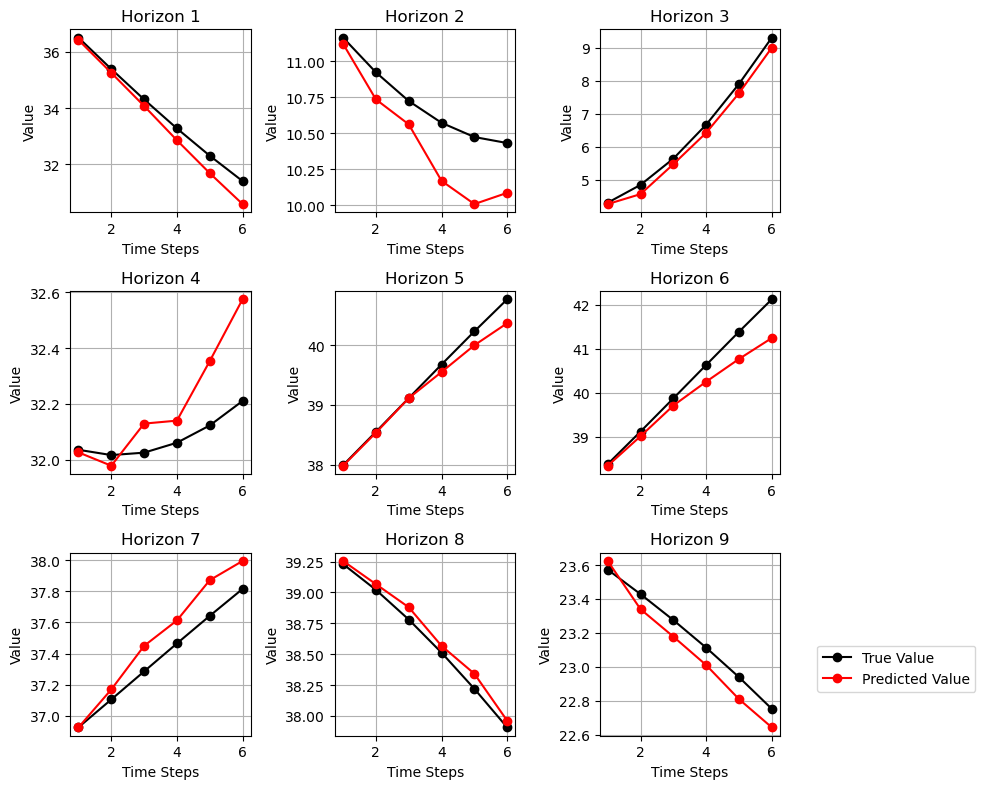

In [47]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'X-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [48]:
## similar process can be performed on Y and Z Dimensions
## just replace x_scaled with y_scaled or z_scaled when calling split_series function

In [49]:
## quantile ver
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.120900
Epoch [10/50], Loss: 0.007148
Epoch [20/50], Loss: 0.002932
Epoch [30/50], Loss: 0.002098
Epoch [40/50], Loss: 0.001784
Epoch [50/50], Loss: 0.001570


In [50]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 6 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 6 time steps(RMSE):
Quantile 0.05: 0.019269
Quantile 0.25: 0.012359
Quantile 0.50: 0.010071
Quantile 0.75: 0.008916
Quantile 0.95: 0.013273


In [51]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(pred_050[: , step], actual_values[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0043
At time step 2, Avg RMSE: 0.0050
At time step 3, Avg RMSE: 0.0080
At time step 4, Avg RMSE: 0.0104
At time step 5, Avg RMSE: 0.0123
At time step 6, Avg RMSE: 0.0156


In [52]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [36.510597 35.390133 34.305557 33.2713   32.29794  31.392473]
At Quantile 0.05: [36.013737 34.725346 33.792713 32.644077 30.800795 29.999212]
At Quantile 0.25: [36.072754 35.067272 33.95737  32.515583 31.408157 30.666409]
At Quantile 0.5: [36.199345 35.030834 33.86242  32.724037 31.614496 30.52644 ]
At Quantile 0.75: [36.251778 34.927967 33.842606 32.674007 31.738955 30.474277]
At Quantile 0.95: [36.738136 35.215977 34.36661  33.513817 32.2445   31.378977]
Actual Values: [11.1629   10.922095 10.7232   10.571853 10.473153 10.431415]
At Quantile 0.05: [10.445619 10.360147 10.013334  9.795297  9.134656  8.718632]
At Quantile 0.25: [10.912467  10.522384  10.416777   9.980493   9.689671   9.4336195]
At Quantile 0.5: [11.0714035 10.717824  10.338319  10.099899  10.10116    9.582216 ]
At Quantile 0.75: [11.057685 10.833747 10.327901 10.219233 10.405214 10.39162 ]
At Quantile 0.95: [11.208262 11.197213 10.737425 10.843642 11.538242 10.993

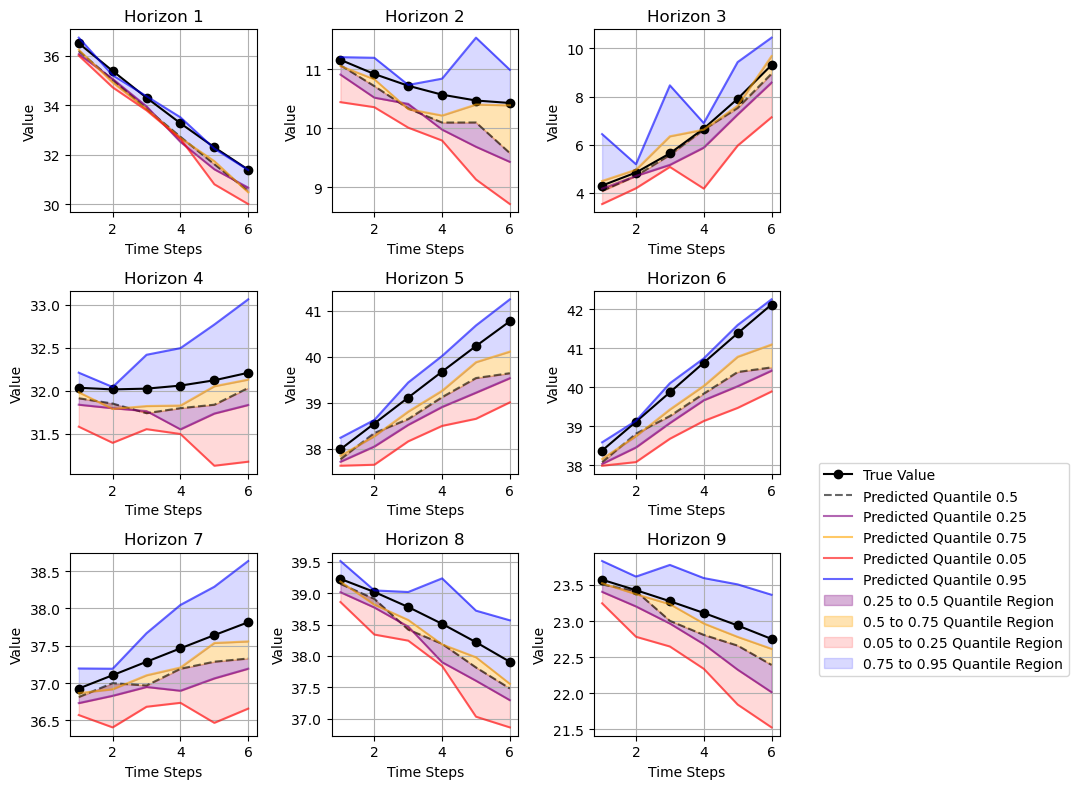

In [53]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'X-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [54]:
# some of the results looks pretty good...

mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Average Performance
MAE: 0.3665, MAPE: 1.8613%


In [55]:
for step in range(output_size):
    mae_step = mean_absolute_error(predicted_050[: , step], actual_values[:, step])
    mape_step = mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step])
    print(f"At time step {step + 1}, predictions have MAE: {mae_step:.4f} and MAPE: {mape_step*100:.4f}%")

At time step 1, predictions have MAE: 0.1554 and MAPE: 0.8114%
At time step 2, predictions have MAE: 0.1900 and MAPE: 0.9946%
At time step 3, predictions have MAE: 0.3341 and MAPE: 1.6134%
At time step 4, predictions have MAE: 0.4294 and MAPE: 2.2399%
At time step 5, predictions have MAE: 0.5008 and MAPE: 2.6294%
At time step 6, predictions have MAE: 0.5895 and MAPE: 3.1168%


In [56]:
## similar process can be performed on Y and Z Dimensions
## just replace x_scaled with y_scaled or z_scaled when calling split_series function

In [107]:
# I will include Y & Z Dimensions here as a bonus

input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(y_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

# Hyperparameters
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50    # Default: 50, change for less intentive computation
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.018307
Epoch [10/50], Loss: 0.003102
Epoch [20/50], Loss: 0.001462
Epoch [30/50], Loss: 0.000776
Epoch [40/50], Loss: 0.000108
Epoch [50/50], Loss: 0.000070


In [108]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

## Calculate RMSE here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.011578


In [109]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(y_pred[:, step], y_test[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0060
At time step 2, Avg RMSE: 0.0073
At time step 3, Avg RMSE: 0.0081
At time step 4, Avg RMSE: 0.0104
At time step 5, Avg RMSE: 0.0148
At time step 6, Avg RMSE: 0.0179


In [110]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[25.405724 24.721567 24.200329 23.726967 23.76368  23.718222]
 [12.735492 12.928228 13.047182 13.153598 13.444053 13.399294]
 [14.032439 15.588329 18.7638   20.600574 22.965254 25.351788]
 ...
 [22.065485 21.879433 21.713694 21.527388 21.472914 21.464115]
 [22.37735  22.122843 21.917952 21.684885 21.637205 21.640717]
 [32.65209  33.196728 33.581314 33.96383  34.57095  34.903538]]
True values: [[24.887672  24.318254  23.88349   23.565454  23.345333  23.20479  ]
 [12.511562  12.644879  12.8517    13.132195  13.484336  13.903755 ]
 [13.2317705 15.535343  17.895847  20.209808  22.383417  24.342335 ]
 ...
 [21.80781   21.696058  21.563877  21.410824  21.236387  21.039957 ]
 [22.035442  21.817411  21.5843    21.334564  21.066572  20.778608 ]
 [32.56835   33.1345    33.7419    34.39163   35.08408   35.818745 ]]


In [111]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 0.4280, MAPE on test set: 2.3840%


In [112]:
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

actual_values_steps = list(zip(*actual_values))
predicted_values_steps = list(zip(*predicted_values))

for step in range(output_size):
    mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
    mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))
    print(f"At time step {step + 1}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

At time step 1, Avg MAE: 0.27, Avg MAPE: 1.339%
At time step 2, Avg MAE: 0.31, Avg MAPE: 1.652%
At time step 3, Avg MAE: 0.31, Avg MAPE: 1.626%
At time step 4, Avg MAE: 0.38, Avg MAPE: 2.239%
At time step 5, Avg MAE: 0.58, Avg MAPE: 3.375%
At time step 6, Avg MAE: 0.71, Avg MAPE: 4.072%


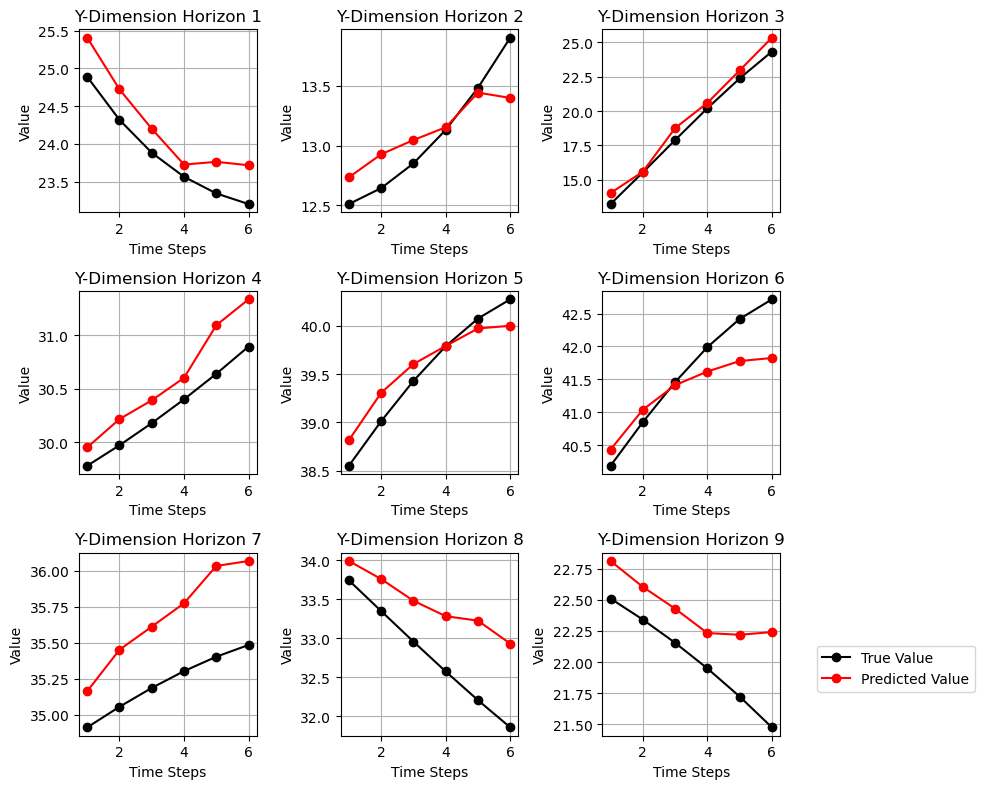

In [113]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Y-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [114]:
## quantile ver
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.113452
Epoch [10/50], Loss: 0.007794
Epoch [20/50], Loss: 0.006039
Epoch [30/50], Loss: 0.005009
Epoch [40/50], Loss: 0.003954
Epoch [50/50], Loss: 0.003208


In [115]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 6 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 6 time steps(RMSE):
Quantile 0.05: 0.028195
Quantile 0.25: 0.017139
Quantile 0.50: 0.015574
Quantile 0.75: 0.018188
Quantile 0.95: 0.040236


In [116]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(pred_050[: , step], actual_values[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0049
At time step 2, Avg RMSE: 0.0081
At time step 3, Avg RMSE: 0.0118
At time step 4, Avg RMSE: 0.0150
At time step 5, Avg RMSE: 0.0197
At time step 6, Avg RMSE: 0.0248


In [117]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [24.887672 24.318254 23.88349  23.565454 23.345333 23.20479 ]
At Quantile 0.05: [24.620548 24.304993 23.506409 23.42567  23.136497 22.648685]
At Quantile 0.25: [25.005373 23.942204 23.459375 22.826553 23.208757 22.050846]
At Quantile 0.5: [25.091341 23.964722 23.397415 22.953814 22.335932 22.066708]
At Quantile 0.75: [24.779737 24.197985 23.660387 22.982386 22.779613 21.767107]
At Quantile 0.95: [25.28992  24.650465 24.919357 24.675615 24.952566 24.357162]
Actual Values: [12.511562 12.644879 12.8517   13.132195 13.484336 13.903755]
At Quantile 0.05: [12.134541 11.753713 11.064996 11.03814  11.271545 10.412488]
At Quantile 0.25: [12.0360565 12.179397  12.213082  12.413425  12.0350275 12.14683  ]
At Quantile 0.5: [12.399868 12.429373 12.491827 12.53966  12.735538 13.413667]
At Quantile 0.75: [12.415975 12.628379 13.003894 13.032828 13.56407  13.730971]
At Quantile 0.95: [12.92788  13.035031 13.285886 14.893885 15.096974 15.978972]
A

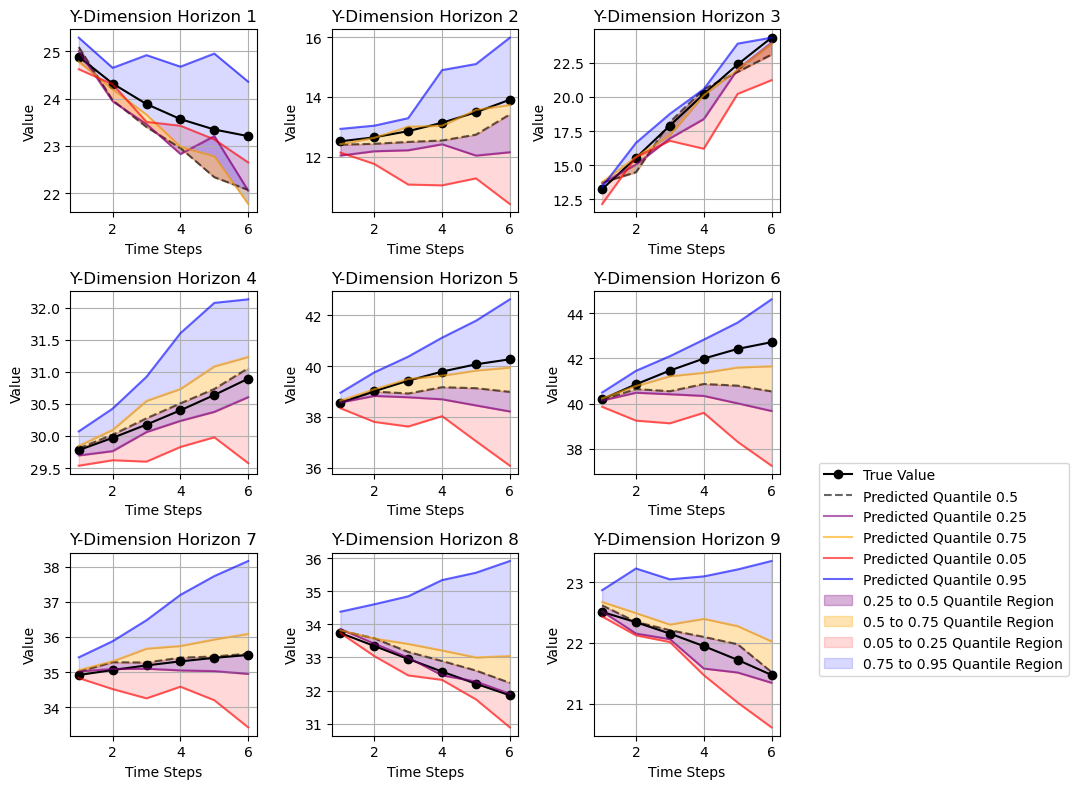

In [118]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Y-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [119]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Average Performance
MAE: 0.4598, MAPE: 2.5847%


In [120]:
for step in range(output_size):
    mae_step = mean_absolute_error(predicted_050[: , step], actual_values[:, step])
    mape_step = mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step])
    print(f"At time step {step + 1}, predictions have MAE: {mae_step:.4f} and MAPE: {mape_step*100:.4f}%")

At time step 1, predictions have MAE: 0.1391 and MAPE: 0.8695%
At time step 2, predictions have MAE: 0.2465 and MAPE: 1.5027%
At time step 3, predictions have MAE: 0.3678 and MAPE: 2.2522%
At time step 4, predictions have MAE: 0.4837 and MAPE: 3.2944%
At time step 5, predictions have MAE: 0.6683 and MAPE: 3.9701%
At time step 6, predictions have MAE: 0.8533 and MAPE: 44.1356%


In [121]:
## Z-Dimension
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(z_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

# Hyperparameters
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50    # Default: 50, change for less intentive computation
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.012040
Epoch [10/50], Loss: 0.000131
Epoch [20/50], Loss: 0.000058
Epoch [30/50], Loss: 0.000065
Epoch [40/50], Loss: 0.000053
Epoch [50/50], Loss: 0.000044


In [122]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

## Calculate RMSE here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.006014


In [123]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(y_pred[:, step], y_test[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0032
At time step 2, Avg RMSE: 0.0035
At time step 3, Avg RMSE: 0.0047
At time step 4, Avg RMSE: 0.0062
At time step 5, Avg RMSE: 0.0072
At time step 6, Avg RMSE: 0.0090


In [124]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[35.21601  34.25472  33.311314 32.449    31.591915 30.931091]
 [28.190739 28.75111  29.473722 30.162722 30.638435 31.212507]
 [42.063404 42.594273 43.070354 43.072624 42.686615 41.753536]
 ...
 [20.206753 19.645227 19.281584 18.749327 18.375498 17.962679]
 [17.870903 17.388506 17.084553 16.645199 16.38837  16.127491]
 [12.98529  12.989966 12.985587 13.024728 13.118263 13.552836]]
True values: [[35.09008  34.128872 33.153397 32.182415 31.229223 30.302485]
 [28.05987  28.73555  29.401558 30.045137 30.653187 31.212788]
 [41.63787  42.504402 42.926632 42.912464 42.500385 41.75292 ]
 ...
 [20.123291 19.651169 19.199312 18.767834 18.357023 17.967361]
 [17.758703 17.364485 16.988771 16.632338 16.296131 15.981294]
 [13.104036 13.081644 13.110209 13.196344 13.3476   13.572527]]


In [131]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 0.1671, MAPE on test set: 0.7244%


In [134]:
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

actual_values_steps = list(zip(*actual_values))
predicted_values_steps = list(zip(*predicted_values))

for step in range(output_size):
    mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
    mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))
    print(f"At time step {step + 1}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

At time step 1, Avg MAE: 0.11, Avg MAPE: 0.496%
At time step 2, Avg MAE: 0.10, Avg MAPE: 0.462%
At time step 3, Avg MAE: 0.14, Avg MAPE: 0.557%
At time step 4, Avg MAE: 0.18, Avg MAPE: 0.786%
At time step 5, Avg MAE: 0.21, Avg MAPE: 0.905%
At time step 6, Avg MAE: 0.27, Avg MAPE: 1.141%


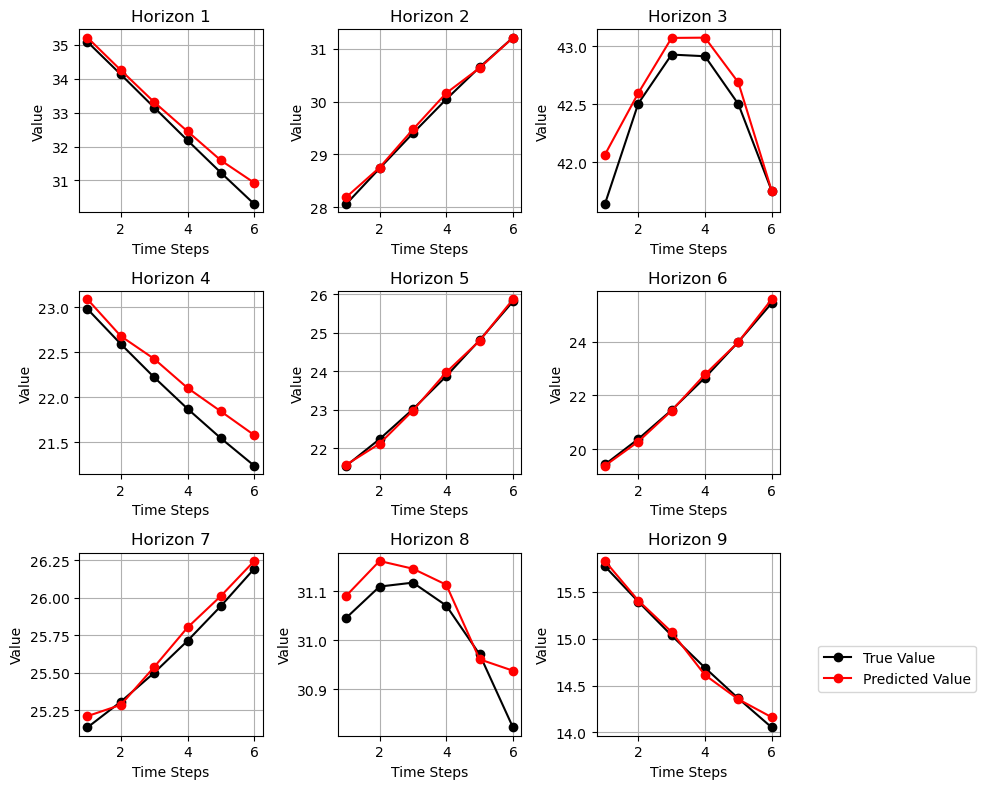

In [135]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [136]:
## quantile ver
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.116123
Epoch [10/50], Loss: 0.005411
Epoch [20/50], Loss: 0.001871
Epoch [30/50], Loss: 0.001547
Epoch [40/50], Loss: 0.001396
Epoch [50/50], Loss: 0.001312


In [137]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 6 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 6 time steps(RMSE):
Quantile 0.05: 0.012435
Quantile 0.25: 0.007186
Quantile 0.50: 0.007198
Quantile 0.75: 0.008060
Quantile 0.95: 0.017955


In [138]:
rmse_steps = [[] for _ in range(output_size)]

for step in range(output_size):
    mse_step = mean_squared_error(pred_050[: , step], actual_values[:, step])
    rmse_steps[step].append(np.sqrt(mse_step))
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}")

At time step 1, Avg RMSE: 0.0045
At time step 2, Avg RMSE: 0.0054
At time step 3, Avg RMSE: 0.0059
At time step 4, Avg RMSE: 0.0072
At time step 5, Avg RMSE: 0.0085
At time step 6, Avg RMSE: 0.0101


In [139]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [35.09008  34.128872 33.153397 32.182415 31.229223 30.302485]
At Quantile 0.05: [34.641705 33.955677 33.00115  32.124577 31.06272  29.960901]
At Quantile 0.25: [35.03195  34.262672 33.321358 32.230045 31.236933 30.416668]
At Quantile 0.5: [35.29033  34.431995 33.441185 32.403862 31.463638 30.474657]
At Quantile 0.75: [35.418217 34.553944 33.58222  32.74699  32.01925  31.000748]
At Quantile 0.95: [35.673046 35.251034 35.496883 33.649925 33.247414 32.48597 ]
Actual Values: [28.05987  28.73555  29.401558 30.045137 30.653187 31.212788]
At Quantile 0.05: [27.822273 28.480398 29.141027 29.830275 30.370752 30.85187 ]
At Quantile 0.25: [28.071342 28.804796 29.466219 29.979515 30.5409   31.0528  ]
At Quantile 0.5: [28.203545 28.920649 29.525057 30.143774 30.704    31.162287]
At Quantile 0.75: [28.242315 28.956448 29.580873 30.175003 30.75173  31.230701]
At Quantile 0.95: [28.370613 29.055656 29.928436 30.662756 31.118635 31.779696]
Actual 

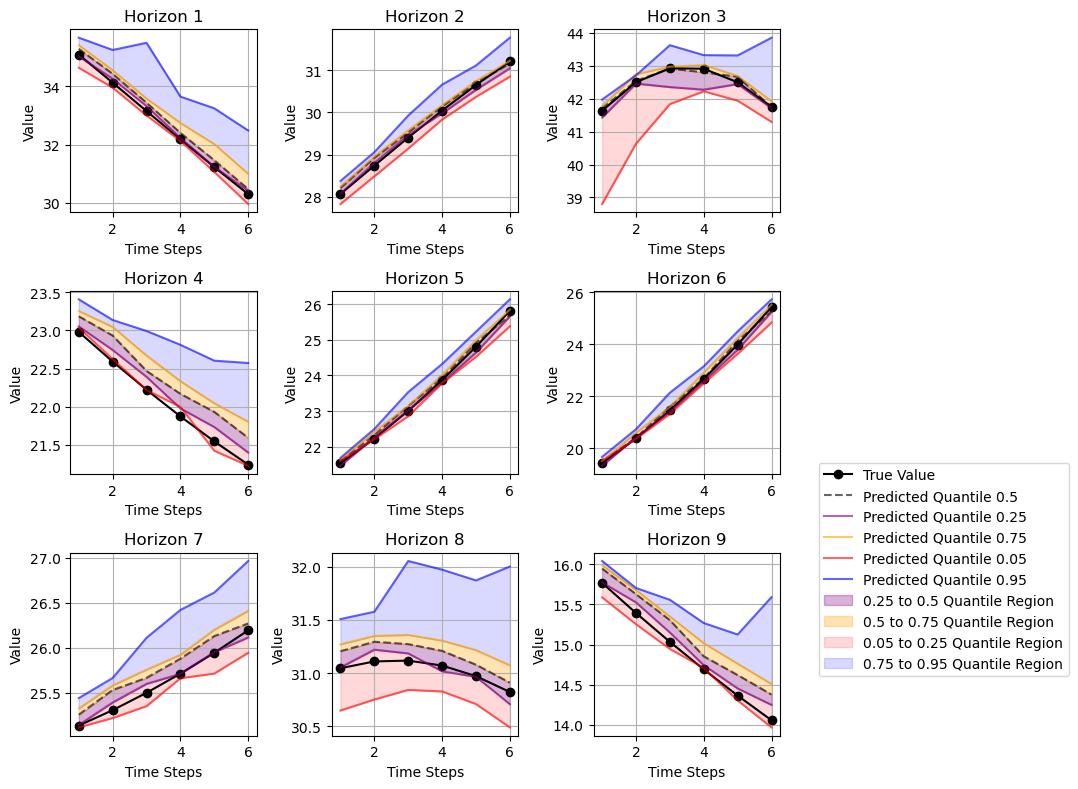

In [140]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for i in range(9):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha = 0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [141]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Average Performance
MAE: 0.2228, MAPE: 1.1231%


In [142]:
for step in range(output_size):
    mae_step = mean_absolute_error(predicted_050[: , step], actual_values[:, step])
    mape_step = mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step])
    print(f"At time step {step + 1}, predictions have MAE: {mae_step:.4f} and MAPE: {mape_step*100:.4f}%")

At time step 1, predictions have MAE: 0.1813 and MAPE: 0.8807%
At time step 2, predictions have MAE: 0.2222 and MAPE: 1.0195%
At time step 3, predictions have MAE: 0.2097 and MAPE: 1.0201%
At time step 4, predictions have MAE: 0.2076 and MAPE: 0.9831%
At time step 5, predictions have MAE: 0.2452 and MAPE: 1.1146%
At time step 6, predictions have MAE: 0.2710 and MAPE: 4.5061%
